In [1]:
pip install benchmarkfcns==2.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 kB 2.4 MB/s eta 0:00:00


In [2]:
import torch
import matplotlib.pyplot as plt
from benchmarkfcns import booth
torch.set_default_dtype(torch.float64)

Booth Function
$$f(x,y)=(x+2y-7)^2+(2x+y-5)^2$$
$$∇f(\mathbf{x}) = (2(x+2y-7) + 4(2x+y-5), 4(x+2y-7) + 2(2x+y-5))$$


$$= \begin{bmatrix}
2x + 4y - 14 + 8x + 4y - 20 \\
4x + 8y - 28 + 4x + 2y - 10
\end{bmatrix}$$


$$H_f(x) =
\begin{bmatrix}
10 & 8 \\
8 & 10
\end{bmatrix}$$

In [3]:
n = 2

# function
def f(x):
  x1, y1 = x[0], x[1]  # unpack x and y
  result = (x1 + 2 * y1 - 7) ** 2 + (2 * x1 + y1 - 5) ** 2
  return result

# gradient
def grad_f(x):
  x1, y1 = x[0], x[1]
  df_dx1 = 2 * (x1 + 2 * y1 - 7) + 4 * (2 * x1 + y1 - 5)
  df_dx2 = 4 * (x1 + 2 * y1 - 7) + 2 * (2 * x1 + y1 - 5)
  return torch.tensor([df_dx1, df_dx2], dtype=x.dtype, device=x.device)

#hessian definition
def hes(x):
  return torch.tensor([[10, 8], [8, 10]], dtype=x.dtype, device=x.device)

#gradient using AD
def grad_f_AD(x):
  dim = x.shape[0]
  assert x.shape == (dim, 1) # ensuring input is valid in context
  #track the input
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs=y, inputs=x,grad_outputs=torch.ones_like(y), create_graph=True)[0]

  #detach variables to release memeory
  x = x.detach()
  y = y.detach()
  dy = dy.detach()

  return dy

#hessian using AD
def hes_f_AD(x):
  x.requires_grad = True
  y = f(x)
  dy = torch.autograd.grad(outputs = y, inputs = x, grad_outputs = torch.ones_like(y), create_graph = True)[0]

  #initialize hessian
  dim = x.shape[0]
  H = torch.zeros((dim, dim), dtype=x.dtype, device=x.device)

  #identity matrix
  I = torch.eye(dim, dtype=x.dtype, device = x.device)

  # for loop through identity matrix to compute second derivates
  for i in range(dim):
    grad_output = I[i].unsqueeze(-1)
    second_grad = torch.autograd.grad(outputs=dy, inputs = x, grad_outputs=grad_output, create_graph=True)[0]
    H[i] = second_grad.squeeze()

  #detach variables
  H = H.detach()
  dy = dy.detach()
  x = x.detach()

  return H

In [4]:
#test function
X = torch.rand(1000, n)

f1Out = booth(X)
passed = True

for i in range(1000):
  f2 = f(X[i])
  # print(X[i].shape)
  if abs(f1Out[i] - f2) > .0005:
    passed = False
    print('error')
    print(f1Out[i])
    #print(X[i])
    print(f2)
    break
if passed:
  print('passed')

passed


In [5]:
dim = n
x = torch.randn(dim,1)
v = torch.randn_like(x)
v = v / torch.norm(v)

max_iters = 32
h = torch.zeros(max_iters)
err0 = torch.zeros(max_iters) # error from zero order T.P.
err1 = torch.zeros(max_iters)
err2 = torch.zeros(max_iters)

for i in range(max_iters):
  h[i] = 2**(-i) # iterate h down

  #regular
  fv = f(x + h[i]*v)
  T0 = f(x)
  T1 = T0 + h[i] * (grad_f(x)).T @ v
  T2 = T1 + .5*(h[i]**2) * v.T @ hes(x) @ v

  #using AD
  # fv = f(x+h[i]*v).detach()
  # T0 = f(x).detach()
  # T1 = T0 + h[i] * (grad_f_AD(x)).T @ v
  # T2 = T1 + .5*(h[i]**2) * v.T @ hes_f_AD(x) @ v


  err0[i] = torch.norm(fv - T0)
  err1[i] = torch.norm(fv - T1)
  err2[i] = torch.norm(fv - T2)
  print('h: %.3e, \t err0: %.3e, \t err1: %.3e, \t err2: %.3e' % (h[i], err0[i], err1[i], err2[i]))

h: 1.000e+00, 	 err0: 8.319e+00, 	 err1: 1.043e+00, 	 err2: 0.000e+00
h: 5.000e-01, 	 err0: 3.899e+00, 	 err1: 2.607e-01, 	 err2: 0.000e+00
h: 2.500e-01, 	 err0: 1.884e+00, 	 err1: 6.518e-02, 	 err2: 2.842e-14
h: 1.250e-01, 	 err0: 9.258e-01, 	 err1: 1.630e-02, 	 err2: 0.000e+00
h: 6.250e-02, 	 err0: 4.588e-01, 	 err1: 4.074e-03, 	 err2: 0.000e+00
h: 3.125e-02, 	 err0: 2.284e-01, 	 err1: 1.018e-03, 	 err2: 2.842e-14
h: 1.562e-02, 	 err0: 1.139e-01, 	 err1: 2.546e-04, 	 err2: 2.842e-14
h: 7.812e-03, 	 err0: 5.691e-02, 	 err1: 6.365e-05, 	 err2: 0.000e+00
h: 3.906e-03, 	 err0: 2.844e-02, 	 err1: 1.591e-05, 	 err2: 2.842e-14
h: 1.953e-03, 	 err0: 1.421e-02, 	 err1: 3.978e-06, 	 err2: 0.000e+00
h: 9.766e-04, 	 err0: 7.106e-03, 	 err1: 9.946e-07, 	 err2: 0.000e+00
h: 4.883e-04, 	 err0: 3.553e-03, 	 err1: 2.486e-07, 	 err2: 2.842e-14
h: 2.441e-04, 	 err0: 1.776e-03, 	 err1: 6.216e-08, 	 err2: 0.000e+00
h: 1.221e-04, 	 err0: 8.882e-04, 	 err1: 1.554e-08, 	 err2: 0.000e+00
h: 6.104e-05, 	 err0

<ipython-input-5-afd8e6bb95b9>:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  T1 = T0 + h[i] * (grad_f(x)).T @ v


(array([1.e-17, 1.e-15, 1.e-13, 1.e-11, 1.e-09, 1.e-07, 1.e-05, 1.e-03,
        1.e-01, 1.e+01, 1.e+03, 1.e+05]),
 [Text(0, 1e-17, '$\\mathdefault{10^{-17}}$'),
  Text(0, 1e-15, '$\\mathdefault{10^{-15}}$'),
  Text(0, 1e-13, '$\\mathdefault{10^{-13}}$'),
  Text(0, 1e-11, '$\\mathdefault{10^{-11}}$'),
  Text(0, 1e-09, '$\\mathdefault{10^{-9}}$'),
  Text(0, 1e-07, '$\\mathdefault{10^{-7}}$'),
  Text(0, 1e-05, '$\\mathdefault{10^{-5}}$'),
  Text(0, 0.001, '$\\mathdefault{10^{-3}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$')])

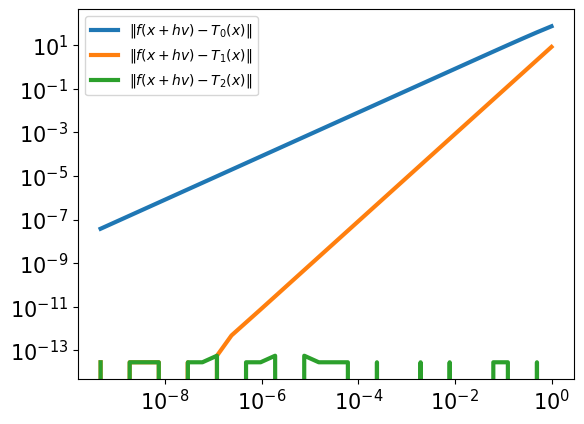

In [ ]:
plt.loglog(h, err0, linewidth = 3)
plt.loglog(h, err1, linewidth = 3)
plt.loglog(h, err2, linewidth = 3)
plt.legend(['$\|f(x+hv) - T_0(x)\|$', '$\|f(x+hv) - T_1(x)\|$', '$\|f(x+hv) - T_2(x)\|$'])
plt.xticks(fontsize =15)
plt.yticks(fontsize =15)